In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Prepare Data

In [52]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize the graph
G = nx.DiGraph()

# Define the layers and number of nodes
layers = {
    'Input': 5,
    'Hidden': 4,
    'Output': 3
}

# Assign positions for each node in each layer
pos = {}
layer_names = list(layers.keys())
layer_positions = {layer: i for i, layer in enumerate(layer_names)}

# Place nodes in the graph
for layer, num_nodes in layers.items():
    for i in range(num_nodes):
        pos[f"{layer}_{i}"] = (layer_positions[layer], num_nodes - i - 1)

# Add edges between layers (fully connected)
for i in range(layers['Input']):
    for j in range(layers['Hidden']):
        G.add_edge(f"Input_{i}", f"Hidden_{j}")

for i in range(layers['Hidden']):
    for j in range(layers['Output']):
        G


In [36]:
CD138Cells_Proteomics = pd.read_csv("/Users/SJp/Documents/Projects/PatStrat/data/CD138Cells_Proteomics.csv")

print(len(CD138Cells_Proteomics))
# Split the 'values' column by '|'
CD138Cells_Proteomics['ID'] = CD138Cells_Proteomics['ID'].str.split('|')

# Use explode to split lists into separate rows
CD138Cells_Proteomics = CD138Cells_Proteomics.explode('ID').reset_index(drop=True)
CD138Cells_Proteomics.dropna(inplace=True)
CD138Cells_Proteomics.reset_index(inplace=True, drop=True)



5663
4757


In [41]:
clinical = pd.read_csv("/Users/SJp/Documents/Projects/PatStrat/data/Clinical.csv", index_col=0).transpose()
clinical

ID,Diagnosis,Prior_Treatment_Lines_simplified,Treatment_stage,Age_At_Sampling,Deceased,Gender,Kap_Lam_clonality,Ig_Subtype,Clonality,Pathology,...,Prior_Immunotherapy,Prior_AlloTPL,Prior_Number_of_Treatment_Lines,PhenoGroups,%_Myeloma_cells_by_PCY,%_SmallPlasma_cells_by_PCY,%_Plasma_cells_by_PCY,%_M0_cells_by_PCY,%_Other_cells_by_PCY,%_T3_cells_by_PCY
MM001,Plasma cell myeloma,3+,treatment control,72,1,m,Kappa,IgG-Kappa,not clonal,NaN,...,NaN,NaN,3,na,NaN,NaN,NaN,NaN,NaN,NaN
MM002,Plasma cell myeloma,1,treatment control,63,0,f,Kappa,IgG-Kappa,clonal,35,...,0,0,1,na,NaN,NaN,NaN,NaN,NaN,NaN
MM003,Plasma cell myeloma,0,untreated,75,1,m,Kappa,IgG-Kappa,clonal,45,...,0,0,0,na,NaN,NaN,NaN,NaN,NaN,NaN
MM004,Plasma cell myeloma,1,relapse/progress,67,0,m,Kappa,IgG-Kappa,clonal,25,...,0,0,1,na,NaN,NaN,NaN,NaN,NaN,NaN
MM005,Plasma cell myeloma,0,relapse/progress,72,0,m,Kappa,IgA-Kappa,clonal,45,...,0,0,0,na,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MM144,Plasma cell leukemia,1,relapse/progress,62,0,m,Kappa,IgA-Kappa,clonal,50,...,0,1,1,na,0.85,10.4,11.26,3.86,68.68,16.21
MM145,Plasma cell myeloma,0,treatment control,46,0,m,Kappa,IgG-Kappa,clonal,31,...,NaN,NaN,NaN,na,NaN,NaN,NaN,NaN,NaN,NaN
MM146,Plasma cell myeloma,0,untreated,61,0,m,Kappa,IgG-Kappa,clonal,20,...,0,0,0,na,NaN,NaN,NaN,NaN,NaN,NaN
MM147,Plasma cell myeloma,0,untreated,49,0,m,Kappa,IgG-Kappa,clonal,80,...,0,0,0,na,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
set(clinical['Treatment_stage'])

{'control after allo-TPL',
 nan,
 'relapse/progress',
 'treatment control',
 'untreated'}

In [44]:
total_Samples = len(clinical)
total_Samples

139

In [45]:
placebo_samples = clinical[clinical['Treatment_stage']=='treatment control']
len(placebo_samples)

44

In [46]:
untreated_samples = clinical[clinical['Treatment_stage']=='untreated']
len(untreated_samples)


38

In [47]:
in_treatment = clinical[clinical['Treatment_stage']=='relapse/progress']
len(in_treatment)

40

In [50]:
ctrl_after_treatment = clinical[clinical['Treatment_stage']=='control after allo-TPL']
len(ctrl_after_treatment)

16

{'control after allo-TPL',
 nan,
 'relapse/progress',
 'treatment control',
 'untreated'}

In [2]:
# Step 1: Data Preparation
data = {
    'patient_id': range(100),
    'feature1': np.random.rand(100),
    'feature2': np.random.rand(100),
    'treatment_line': np.random.choice(['line1', 'line2'], 100),
    'drug_response': np.random.rand(100) * 100
}
df = pd.DataFrame(data)

# Preprocess data
scaler = StandardScaler()
df[['feature1', 'feature2']] = scaler.fit_transform(df[['feature1', 'feature2']])


In [7]:
df

,patient_id,feature1,feature2,treatment_line,drug_response
0,0,-1.629874,-1.416849,line2,12.330224
1,1,0.534994,-0.701450,line1,40.643777
2,2,0.771966,-0.186166,line2,25.021346
3,3,1.257691,-0.944950,line1,34.727850
4,4,0.366914,-0.553074,line1,58.635551
...,...,...,...,...,...
95,95,-0.529216,0.076436,line2,46.607538
96,96,-1.723991,0.084552,line2,62.455377
97,97,-0.346931,-1.325357,line1,66.827212
98,98,0.405414,1.357542,line1,28.941951


In [3]:
# Step 2: Compute Similarity Networks
def compute_similarity_network(df, treatment_line):
    sub_df = df[df['treatment_line'] == treatment_line]
    patient_ids = sub_df['patient_id'].values
    features = sub_df[['feature1', 'feature2']].values
    similarity_matrix = np.exp(-np.linalg.norm(features[:, np.newaxis] - features, axis=2))  # Gaussian similarity
    G = nx.Graph()
    for i, pid in enumerate(patient_ids):
        for j, pid2 in enumerate(patient_ids):
            if i != j:
                G.add_edge(pid, pid2, weight=similarity_matrix[i, j])
    return G

networks = {line: compute_similarity_network(df, line) for line in df['treatment_line'].unique()}


In [4]:
# Step 3: Graph Embedding with PyTorch Geometric Node2Vec
def get_node2vec_embeddings(G, node_ids):
    data = from_networkx(G)
    node2vec = Node2Vec(data.edge_index, embedding_dim=64, walk_length=30, context_size=10, walks_per_node=10, num_negative_samples=1, sparse=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    node2vec = node2vec.to(device)
    data = data.to(device)

    optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

    def train():
        node2vec.train()
        loader = node2vec.loader(batch_size=64, shuffle=True, num_workers=0)
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    for epoch in range(100):  # Adjust the number of epochs based on your needs
        loss = train()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')

    embeddings = node2vec.embedding.weight.detach().cpu().numpy()
    node_id_map = {str(i): node_ids[i] for i in range(len(node_ids))}
    return {node_id_map[str(i)]: embeddings[i] for i in range(len(node_ids))}

embeddings = {line: get_node2vec_embeddings(networks[line], node_ids=list(networks[line].nodes)) for line in networks}


Epoch 0, Loss: 7.00840425491333
Epoch 10, Loss: 5.685626983642578
Epoch 20, Loss: 4.640421390533447
Epoch 30, Loss: 3.954914093017578
Epoch 40, Loss: 3.4252443313598633
Epoch 50, Loss: 3.0368330478668213
Epoch 60, Loss: 2.7442824840545654
Epoch 70, Loss: 2.5792932510375977
Epoch 80, Loss: 2.396108865737915
Epoch 90, Loss: 2.3143460750579834
Epoch 0, Loss: 7.294952392578125
Epoch 10, Loss: 5.888785362243652
Epoch 20, Loss: 4.818312644958496
Epoch 30, Loss: 4.032665729522705
Epoch 40, Loss: 3.48004150390625
Epoch 50, Loss: 3.0650224685668945
Epoch 60, Loss: 2.7643847465515137
Epoch 70, Loss: 2.5800018310546875
Epoch 80, Loss: 2.4596352577209473
Epoch 90, Loss: 2.33793306350708


In [5]:
# Step 4: Model Training
trained_models = {}
for line in set(df['treatment_line']):
    sub_df = df[df['treatment_line'] == 'line1'].reset_index(drop=True)
    X = np.array([embeddings['line1'][pid] for pid in sub_df['patient_id']])
    y = sub_df['drug_response'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")
    trained_models[line] = model

Mean Squared Error: 1002.3182316298896
R-squared: 0.022561448689314423
Mean Squared Error: 1002.3182316298896
R-squared: 0.022561448689314423


In [6]:
# Step 5: Predict Drug Response for New Patient
def preprocess_new_patient(new_patient_data, scaler):
    features = np.array([new_patient_data['feature1'], new_patient_data['feature2']]).reshape(1, -1)
    return scaler.transform(features)

def add_new_patient_to_graph(G, new_patient_data, existing_patient_data):
    new_patient_id = new_patient_data['patient_id']
    G.add_node(new_patient_id)
    new_patient_features = new_patient_data[['feature1', 'feature2']].values
    for existing_patient_id in existing_patient_data.index:
        existing_features = existing_patient_data.loc[existing_patient_id, ['feature1', 'feature2']].values
        similarity = np.exp(-np.linalg.norm(new_patient_features - existing_features))
        G.add_edge(new_patient_id, existing_patient_id, weight=similarity)
    return G

new_patient_data = {
    'patient_id': 101,
    'feature1': 0.5,
    'feature2': 0.3,
    'treatment_line': 'line1'
}
new_patient_df = pd.DataFrame([new_patient_data])
new_patient_df[['feature1', 'feature2']] = preprocess_new_patient(new_patient_data, scaler)

existing_patient_data = df[df['treatment_line'] == new_patient_data['treatment_line']]
existing_patient_data.set_index('patient_id', inplace=True)
G = networks[new_patient_data['treatment_line']]
G = add_new_patient_to_graph(G, new_patient_df.iloc[0], existing_patient_data)

new_embeddings = get_node2vec_embeddings(G, node_ids=list(G.nodes))
new_patient_embedding = new_embeddings[new_patient_data['patient_id']]

model = trained_models[new_patient_data['treatment_line']]  
predicted_response = model.predict(new_patient_embedding.reshape(1, -1))

print(f"Predicted Drug Response for new patient: {predicted_response}")

Epoch 0, Loss: 7.388625144958496


/opt/anaconda3/envs/patstrat/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Epoch 10, Loss: 5.863734245300293
Epoch 20, Loss: 4.787424564361572
Epoch 30, Loss: 3.9806394577026367
Epoch 40, Loss: 3.457801103591919
Epoch 50, Loss: 2.996295213699341
Epoch 60, Loss: 2.670349359512329
Epoch 70, Loss: 2.5353941917419434
Epoch 80, Loss: 2.3866069316864014
Epoch 90, Loss: 2.3503589630126953
Predicted Drug Response for new patient: [77.919945]


Drug Response Table:
        Patient 1  Patient 2  Patient 3  Patient 4  Patient 5  Patient 6  \
Drug 1  -0.974297  -0.940550   0.618461   0.727336  -0.579446   0.078219   
Drug 2  -0.234705   0.889352   0.892639  -0.037002  -0.903105   0.603512   
Drug 3  -0.755804   0.327242   0.173670   0.519401  -0.118027   0.790353   
Drug 4  -0.839520  -0.727004   0.543778  -0.775202  -0.141655  -0.411415   
Drug 5   0.982055   0.459872   0.003196  -0.316212   0.414649   0.720802   

        Patient 7  Patient 8  Patient 9  Patient 10  
Drug 1  -0.205206   0.175180   0.384192   -0.816897  
Drug 2  -0.442170   0.851987  -0.724768    0.354461  
Drug 3   0.318289  -0.556701  -0.584866    0.138814  
Drug 4  -0.949655   0.970551   0.126665   -0.816792  
Drug 5   0.182773  -0.139982  -0.357110    0.363506  


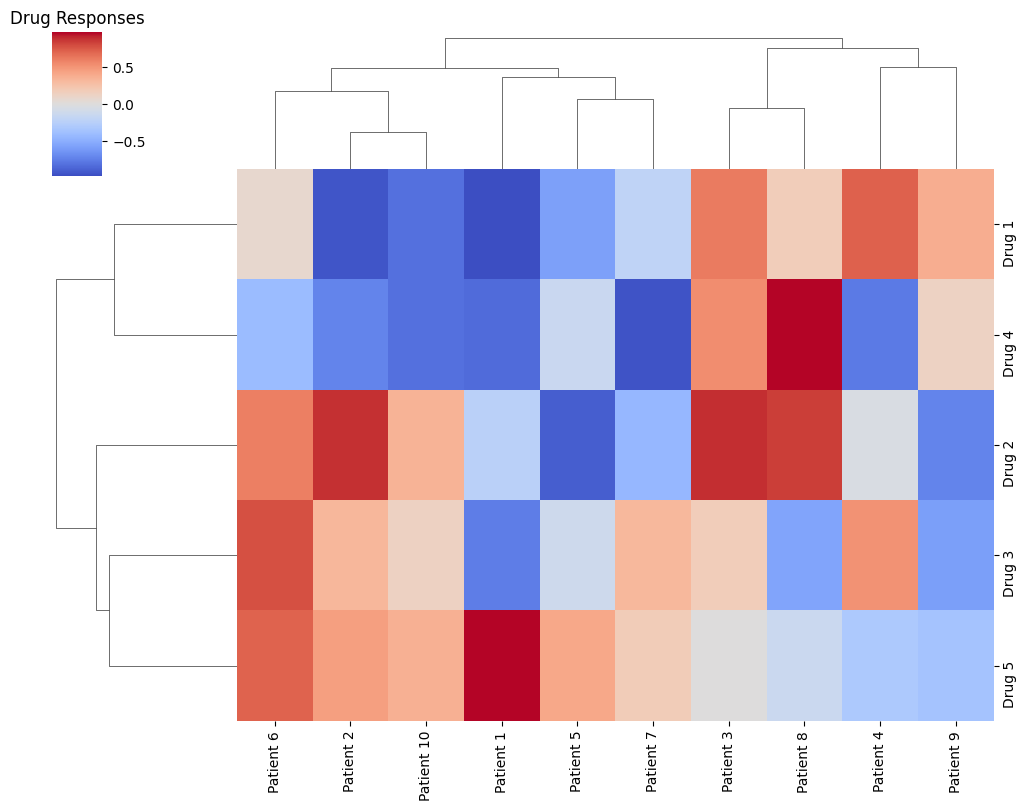

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the drugs and patients
drugs = ['Drug 1', 'Drug 2', 'Drug 3', 'Drug 4', 'Drug 5']
patients = [f'Patient {i}' for i in range(1, 11)]

# Generate random drug response values between -1 and 1
responses = np.random.uniform(-1, 1, size=(len(drugs), len(patients)))

# Create a DataFrame
response_df = pd.DataFrame(responses, index=drugs, columns=patients)

# Display the DataFrame
print("Drug Response Table:")
print(response_df)

# Create a clustergram (clustermap) with customized colorbar
clustermap = sns.clustermap(response_df, cmap='coolwarm', center=0, figsize=(10, 8))

# Display the plot
plt.title("Drug Responses")
plt.show()


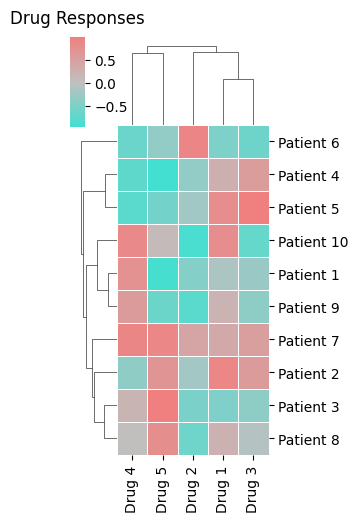

In [59]:
# Define a custom colormap (blue, yellow, orange)
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['turquoise', 'silver', 'lightcoral'])

# Create a clustergram (clustermap) with customized colorbar
clustermap = sns.clustermap(response_df, cmap=custom_cmap, center=0, figsize=(3, 5), linewidths=0.5, linecolor='white')

# Customize the colorbar to be horizontal and placed below the plot

# Adjust the title position if needed
plt.title("Drug Responses", pad=10)

# Display the plot
plt.show()


In [60]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Generate a random data matrix X of size (m x n)
m, n = 1000, 1500
X = np.random.randn(m, n)

In [63]:
k = 10  # number of singular vectors to keep
U, S, Vt = np.linalg.svd(X)
X_approx = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :] # fit data to the model

In [64]:
approx_error = np.linalg.norm(X - X_approx) / np.linalg.norm(X)
print(f'Relative approximation error: {approx_error:.2f}')

Relative approximation error: 0.98


In [65]:
Vk = Vt[:k, :]

In [66]:
feature_importance = np.abs(Vk).sum(axis=0)


In [67]:
feature_importance

array([0.24640072, 0.2179159 , 0.15939925, ..., 0.28054036, 0.16423892,
       0.24315955])

In [68]:
sorted_idx = np.argsort(feature_importance)[::-1]

# Save the names of the top 10 most frequent features in a list
top_features = [feature_names[i] for i in sorted_idx[:10]]

NameError: name 'feature_names' is not defined